In [1]:
import tensorflow as tf
import os
path = "../../Project/"
import pandas as pd
from tensorflow import keras


In [2]:
# Following guide https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
from sklearn.preprocessing import OneHotEncoder

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def get_glove_embedding(path):
    """
    Method to get the embeddings of each word using glove
    :param path: Path to glove files
    :return: Embedding for each word
    """
    embeddings_dict = {}
    with open(path + "glove.6B.300d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict


def find_closest_embeddings(embedding):
    """
    Returns words that are closest to embedded word
    :param embedding: Embedding of chosen word
    :return: List of words closest to that embedded word
    """
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))
# find_closest_embeddings(embeddings_dict["king"])[1:5]


def get_embedding_matrix(series, embeddings_dict):
    """
    Get padded sentence (using unique ids for every word) and embedding matrix for 300 connected words
    :param series: DataFrame Series containing either premise or hypothesis
    :param embeddings_dict: Embedding dict for each word using glove
    :return: padded sentence, embedding matrix and size of vocabulary
    """
    series = series.astype(str)

    token = Tokenizer()
    token.fit_on_texts(series)
    seq = token.texts_to_sequences(series)

    print(series[0])
    print(seq[0])

    print("the max sentence length is:", max([len(x) for x in seq]))
    pad_seq = pad_sequences(seq, maxlen=100)
    vocab_size = len(token.word_index)+1
    print(vocab_size)

    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in token.word_index.items():
        embedding_value = embeddings_dict.get(word)# using glove embedding for each word
        if embedding_value is not None:
            embedding_matrix[i] = embedding_value

    print(pad_seq[4])
    return pad_seq, embedding_matrix, vocab_size


def baseline_sum_sentence_embeddings(pad_seq, embedding_matrix):
    """
    Use baseline embedding of sentence (baseline of the paper)
    Baseline: Sum all embeddings of the words together to get one embedding for the whole sentence.
    :param pad_seq: Padded sequence of either premise or hypothesis
    :param embedding_matrix: Embedded Matrix of every word
    :return: Embedding that is the sum of all embeddings of the words of the sentence
    """
    # Sum embeddings of words together to get embedding of sentence (baseline sentence embedding model)
    sentence_embs = []
    for i in pad_seq:
        sentence_embs.append(sum([embedding_matrix[x] for x in i]))
    sentence_embs = np.array(sentence_embs)
    return sentence_embs


def encode_labels(gold_label):
    """
    One hot encoding of the labels
    :param gold_label: DataFrame Series of gold_labels
    :return: One hot encoding of each label-
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(np.array(gold_label).reshape(-1, 1))

    print(enc.categories_)

    enc_gold_label = enc.transform(np.array(gold_label).reshape(-1, 1)).toarray()

    print(enc_gold_label[0])
    return enc_gold_label

def convert_to_label_names(predictions):
    predicted_label = np.argmax(predictions, axis=1)
    print(np.bincount(predicted_label))
    predicted_label_name = []
    for i in predicted_label:
        if i == 0:
            predicted_label_name.append('contradiction')
        elif i == 1:
            predicted_label_name.append('entailment')
        elif i == 2:
            predicted_label_name.append('neutral')
    print(predicted_label_name[0:10])
    return predicted_label_name

In [3]:
snli_train = pd.read_csv(path+'snli_1.0/snli_1.0_train.txt', sep="\\t")
snli_test = pd.read_csv(path+'snli_1.0/snli_1.0_test.txt', sep="\\t")

C:\Users\Danie\Anaconda3\envs\gameAI\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\Danie\Anaconda3\envs\gameAI\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
print(snli_train['sentence1'][0],snli_train['sentence2'][0], snli_train['gold_label'][0])
print(snli_train['sentence1'][1],snli_train['sentence2'][1], snli_train['gold_label'][1])
print(snli_train['sentence1'][2],snli_train['sentence2'][2], snli_train['gold_label'][2])

A person on a horse jumps over a broken down airplane. A person is training his horse for a competition. neutral
A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette. contradiction
A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse. entailment


In [5]:
# Filter and rename the important columns
train_df = snli_train.filter(['sentence1','sentence2','gold_label'], axis=1)
test_df = snli_test.filter(['sentence1','sentence2','gold_label'], axis=1)
train_df = train_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})
test_df = test_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})

In [6]:
# exclude sentences which could not be categorised
train_df = train_df[train_df['gold_label'] != "-"]
test_df = test_df[test_df['gold_label'] != "-"]

In [7]:
embeddings_dict = get_glove_embedding(path)

In [8]:
pad_seq_prem_test, embedding_matrix_prem_test, vocab_size_prem_test = get_embedding_matrix(test_df['premise'],embeddings_dict)
pad_seq_hyp_test, embedding_matrix_hyp_test, vocab_size_hyp_test = get_embedding_matrix(test_df['hypothesis'],embeddings_dict)

sentence_embs_prem_test = baseline_sum_sentence_embeddings(pad_seq_prem_test, embedding_matrix_prem_test)
sentence_embs_hyp_test = baseline_sum_sentence_embeddings(pad_seq_hyp_test, embedding_matrix_hyp_test)

enc_gold_label_test = encode_labels(test_df['gold_label'])

This church choir sings to the masses as they sing joyous songs from the book at a church.
[281, 668, 779, 600, 12, 3, 2084, 42, 184, 1455, 2085, 2086, 64, 3, 272, 17, 1, 668]
the max sentence length is: 54
4093
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    1   10    9    1   43 1400   22   16    4    1  218
  282 2087]
The church has cracks in the ceiling.
[2, 655, 36, 2754, 6, 2, 2755]
the max sentence length is: 29
5166
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0

In [9]:
new_model = tf.keras.models.load_model('baseline_300000_40epochs')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          30100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          30100       input_2[0][0]                    
______________________________________________________________________________________________

# Analysis

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = new_model.evaluate([sentence_embs_prem_test, sentence_embs_hyp_test], enc_gold_label_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
77/77 [==============================] - ETA: 0s - loss: 0.9376 - accuracy: 0.55 - 1s 5ms/step - loss: 0.9368 - accuracy: 0.5545
test loss, test acc: [0.9368278384208679, 0.5544584393501282]


In [11]:
print("Generate predictions for test")
predictions = new_model.predict([sentence_embs_prem_test, sentence_embs_hyp_test])
print("predictions shape:", predictions.shape)

Generate predictions for test
predictions shape: (9824, 3)


In [12]:
#'contradiction', 'entailment', 'neutral'

In [13]:
predicted_label = np.argmax(predictions, axis=1)

In [14]:
np.bincount(predicted_label)

array([3047, 3461, 3316], dtype=int64)

In [15]:
predicted_label

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [16]:
gold_label = np.argmax(enc_gold_label_test, axis=1)
len(gold_label)

9824

In [17]:
predicted_label_name = []
for i in predicted_label:
    if i == 0:
        predicted_label_name.append('contradiction')
    elif i == 1:
        predicted_label_name.append('entailment')
    elif i == 2:
        predicted_label_name.append('neutral')
print(predicted_label_name[0:10])

['contradiction', 'contradiction', 'contradiction', 'entailment', 'neutral', 'entailment', 'entailment', 'contradiction', 'contradiction', 'entailment']


In [18]:
gold_label_name = test_df['gold_label'].tolist()
print(gold_label_name[0:10])

['neutral', 'entailment', 'contradiction', 'neutral', 'entailment', 'contradiction', 'entailment', 'neutral', 'contradiction', 'neutral']


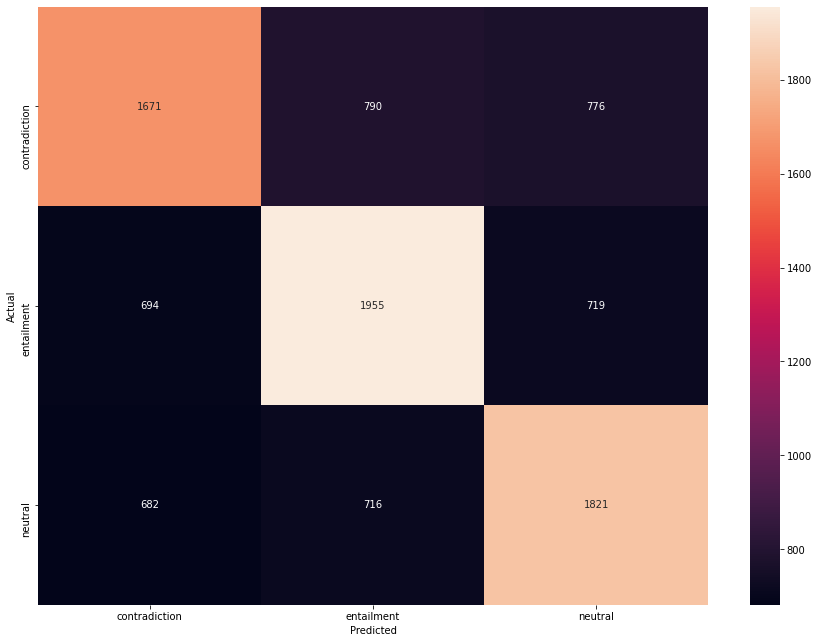

In [19]:
import seaborn as sns
# confusion matrix
d = {'y_predicted':predicted_label_name,'y_true':gold_label_name}
ink_corr_df = pd.DataFrame(d)

confusion_matrix = pd.crosstab(ink_corr_df['y_true'], ink_corr_df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
f = plt.figure(figsize=(15, 11))
sns.heatmap(confusion_matrix, annot=True,fmt='d')
# plt.show()
plt.savefig('conf_matrix_baseline_model.png')

# Percentages

In [20]:
from collections import Counter, defaultdict
# counter of incorrectly predicted tags
incorrect_tags = defaultdict(lambda: defaultdict(list))
# counter of tags that have been confused with each other
confused_tags = defaultdict(lambda: defaultdict(list))
predicted_tags = defaultdict(lambda: defaultdict(list))
prob_of_correct_tag = defaultdict(lambda: defaultdict(list))
all_probs = defaultdict(lambda: defaultdict(list))

predicted_percentage = np.max(predictions, axis=1)
# print(all_tags['neutral'])
for sentence_idx in range(len(predicted_label_name)):
    pred = predicted_label_name[sentence_idx]
    correct = gold_label_name[sentence_idx]
    percentage = predicted_percentage[sentence_idx]
        
    if correct == 'contradiction':
        percentage_correct = predictions[sentence_idx][0]
    elif correct == 'entailment':
        percentage_correct = predictions[sentence_idx][1]
    elif correct == 'neutral':
        percentage_correct = predictions[sentence_idx][2]
    
    predicted_tags[pred][correct].append(percentage)
    prob_of_correct_tag[pred][correct].append(percentage_correct)
    all_probs['contradiction'][correct].append(predictions[sentence_idx][0])
    all_probs['entailment'][correct].append(predictions[sentence_idx][1])
    all_probs['neutral'][correct].append(predictions[sentence_idx][2])
    

In [21]:
labels = ['contradiction', 'entailment', 'neutral']
for l in labels:
    for m in labels:
        items = np.array(predicted_tags[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min())
        items = np.array(prob_of_correct_tag[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min(),"Probs of correct prediction")

Predicted: contradiction Correct: contradiction Max: 0.96697557 Mean: 0.56310004 Min: 0.3389912
Predicted: contradiction Correct: contradiction Max: 0.96697557 Mean: 0.56310004 Min: 0.3389912 Probs of correct prediction
Predicted: contradiction Correct: entailment Max: 0.80643636 Mean: 0.48231837 Min: 0.3352303
Predicted: contradiction Correct: entailment Max: 0.4446289 Mean: 0.27539545 Min: 0.029242877 Probs of correct prediction
Predicted: contradiction Correct: neutral Max: 0.87416434 Mean: 0.5003245 Min: 0.34005606
Predicted: contradiction Correct: neutral Max: 0.47052988 Mean: 0.27341613 Min: 0.05356719 Probs of correct prediction
Predicted: entailment Correct: contradiction Max: 0.8436476 Mean: 0.5039859 Min: 0.33907208
Predicted: entailment Correct: contradiction Max: 0.46965912 Mean: 0.2757347 Min: 0.058790255 Probs of correct prediction
Predicted: entailment Correct: entailment Max: 0.92064923 Mean: 0.5628966 Min: 0.33713296
Predicted: entailment Correct: entailment Max: 0.920

In [22]:
certainty_baseline = []
certainty_baseline_incorrect = []
labels = ['contradiction', 'entailment', 'neutral']
for l in labels:
    for m in labels:
        items = np.array(predicted_tags[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min())
        definitive = items[items>=0.8]
        certain = items[np.logical_and(items<0.8, items>=0.6)]
        normal = items[np.logical_and(items<0.6, items>=0.4)]
#         relatively_uncertain = items[np.logical_and(items<0.4, items>=0.2)]
        uncertain = items[items<0.4]
        print("Definitive:", len(definitive)/len(items), "Certain:", len(certain)/len(items), "Normal:", len(normal)/len(items), "Uncertain:", len(uncertain)/len(items))
        print("")
        if l == m:
            certainty_baseline.append([len(definitive)/len(items),len(certain)/len(items),len(normal)/len(items),len(uncertain)/len(items)])
        else:
            certainty_baseline_incorrect.append([len(definitive)/len(items),len(certain)/len(items),len(normal)/len(items),len(uncertain)/len(items)])

Predicted: contradiction Correct: contradiction Max: 0.96697557 Mean: 0.56310004 Min: 0.3389912
Definitive: 0.05685218432076601 Certain: 0.289048473967684 Normal: 0.5804907241172951 Uncertain: 0.07360861759425494

Predicted: contradiction Correct: entailment Max: 0.80643636 Mean: 0.48231837 Min: 0.3352303
Definitive: 0.002881844380403458 Certain: 0.10230547550432277 Normal: 0.7420749279538905 Uncertain: 0.15273775216138327

Predicted: contradiction Correct: neutral Max: 0.87416434 Mean: 0.5003245 Min: 0.34005606
Definitive: 0.007331378299120235 Certain: 0.14516129032258066 Normal: 0.7140762463343109 Uncertain: 0.13343108504398826

Predicted: entailment Correct: contradiction Max: 0.8436476 Mean: 0.5039859 Min: 0.33907208
Definitive: 0.006329113924050633 Certain: 0.16962025316455695 Normal: 0.6949367088607595 Uncertain: 0.1291139240506329

Predicted: entailment Correct: entailment Max: 0.92064923 Mean: 0.5628966 Min: 0.33713296
Definitive: 0.05319693094629156 Certain: 0.3033248081841432

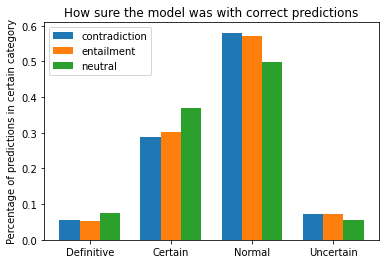

In [23]:
# Certainty if choice was correct
certainty_baseline
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

y = certainty_baseline[0]
z = certainty_baseline[1]
k = certainty_baseline[2]
# k = [11, 12, 13]


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y, width, label=labels[0])
rects2 = ax.bar(x, z, width, label=labels[1])
rects2 = ax.bar(x + width, k, width, label=labels[2])

ax.set_ylabel('Percentage of predictions in certain category')
ax.set_title('How sure the model was with correct predictions')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

# ELMO trained on kaggle

In [24]:
# import tensorflow as tf
# print(tf.__version__)
# import tensorflow_hub as hub

# elmo = hub.load('elmo_3')


In [28]:
import keras
from keras import backend as K
from keras.engine import Layer
import tensorflow_hub as hub
import tensorflow as tf

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
        self.dimensions = 1024
        self.trainable=True

    def build(self, input_shape):
        self.elmo = elmo
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo.signatures['default'](tf.squeeze(tf.cast(x, tf.string), axis=1))['default']
                    #  as_dict=True)
        return result

#     def compute_mask(self, inputs, mask=None):
#         return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [26]:
# # elmo = hub.load('../input/embedding')
# # for i in range(10):
# #     print(i)
# #     embeddings = elmo.signatures['default'](tf.cast(train_df['premise'], tf.string))["default"]
# #     print(embeddings)

# embed_batch_size = 100

# def batch_embed(data, dataset):
#     full_embed = elmo.signatures['default'](tf.cast(data[dataset][0:embed_batch_size], tf.string))['default']

#     for i in range(len(data) // embed_batch_size):
#         print(i * embed_batch_size)
#         current = (i+1)*embed_batch_size
#         tensor = tf.cast(data[dataset][current:current + embed_batch_size], tf.string)
#         embed = elmo.signatures['default'](tensor)['default']
#         full_embed = tf.concat([full_embed, embed], axis=0)

#     print(full_embed)
    
#     return full_embed

# # premise_embed = batch_embed(train_df, 'premise')
# # hypothesis_embed = batch_embed(train_df, 'hypothesis')

# test_premise_embed = batch_embed(test_df, 'premise')
# test_hypothesis_embed = batch_embed(test_df, 'hypothesis')



In [29]:
elmo_model = tf.keras.models.load_model('elmo_300000_40/Elmo_300000_40epochs.hdf5', custom_objects={'ElmoEmbeddingLayer': ElmoEmbeddingLayer})

# Check its architecture
elmo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          614700      concatenate[0][0]     

In [30]:
test_df["label"] = test_df["gold_label"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [32]:
# # # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = elmo_model.evaluate([test_premise_embed, test_hypothesis_embed], y_test, batch_size=128)
# print("test loss, test acc:", results)

In [33]:
predictions_elmo = pd.read_csv("elmo_300000_40/Elmo_test_results_300000_40epochs.csv")
# predictions_elmo = elmo_model.predict([test_premise_embed, test_hypothesis_embed], batch_size=128)
predictions_elmo = predictions_elmo.drop(columns='Unnamed: 0')
predictions_elmo = predictions_elmo.to_numpy()

# Percentages ELMO

In [34]:
predicted_label_name = convert_to_label_names(predictions_elmo)

[3141 3567 3116]
['entailment', 'entailment', 'contradiction', 'neutral', 'neutral', 'entailment', 'entailment', 'neutral', 'entailment', 'neutral']


In [35]:
from collections import Counter, defaultdict
# counter of incorrectly predicted tags
incorrect_tags = defaultdict(lambda: defaultdict(list))
# counter of tags that have been confused with each other
confused_tags = defaultdict(lambda: defaultdict(list))
predicted_tags = defaultdict(lambda: defaultdict(list))
prob_of_correct_tag = defaultdict(lambda: defaultdict(list))
all_probs = defaultdict(lambda: defaultdict(list))

predicted_percentage = np.max(predictions_elmo, axis=1)
# print(all_tags['neutral'])
for sentence_idx in range(len(predicted_label_name)):
    pred = predicted_label_name[sentence_idx]
    correct = gold_label_name[sentence_idx]
    percentage = predicted_percentage[sentence_idx]
    
    if correct == 'contradiction':
        percentage_correct = predictions_elmo[sentence_idx][0]
    elif correct == 'entailment':
        percentage_correct = predictions_elmo[sentence_idx][1]
    elif correct == 'neutral':
        percentage_correct = predictions_elmo[sentence_idx][2]
    
    predicted_tags[pred][correct].append(percentage)
    prob_of_correct_tag[pred][correct].append(percentage_correct)
    all_probs['contradiction'][correct].append(predictions_elmo[sentence_idx][0])
    all_probs['entailment'][correct].append(predictions_elmo[sentence_idx][1])
    all_probs['neutral'][correct].append(predictions_elmo[sentence_idx][2])
    

In [36]:
labels = ['contradiction', 'entailment', 'neutral']
for l in labels:
    for m in labels:
        items = np.array(predicted_tags[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min())
        items = np.array(prob_of_correct_tag[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min(),"Probs of correct prediction")

Predicted: contradiction Correct: contradiction Max: 0.99790937 Mean: 0.6630694479812694 Min: 0.34553272
Predicted: contradiction Correct: contradiction Max: 0.99790937 Mean: 0.6630694479812694 Min: 0.34553272 Probs of correct prediction
Predicted: contradiction Correct: entailment Max: 0.9376126 Mean: 0.5256335294003527 Min: 0.33393565
Predicted: contradiction Correct: entailment Max: 0.46156800000000003 Mean: 0.2624112988007055 Min: 0.015135822 Probs of correct prediction
Predicted: contradiction Correct: neutral Max: 0.9673286 Mean: 0.5475076681595092 Min: 0.34312153
Predicted: contradiction Correct: neutral Max: 0.4856555 Mean: 0.2814587537546013 Min: 0.01940225 Probs of correct prediction
Predicted: entailment Correct: contradiction Max: 0.9698260000000001 Mean: 0.5621700729942694 Min: 0.33935709999999997
Predicted: entailment Correct: contradiction Max: 0.46747723 Mean: 0.2577764054312321 Min: 0.01665385 Probs of correct prediction
Predicted: entailment Correct: entailment Max: 0

In [37]:
labels = ['contradiction', 'entailment', 'neutral']
certainty = []
certainty_incorrect = []
for l in labels:
    for m in labels:
        items = np.array(predicted_tags[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min())
        definitive = items[items>=0.8]
        certain = items[np.logical_and(items<0.8, items>=0.6)]
        normal = items[np.logical_and(items<0.6, items>=0.4)]
#         relatively_uncertain = items[np.logical_and(items<0.4, items>=0.2)]
        uncertain = items[items<0.4]
        print("Definitive:", len(definitive)/len(items), "Certain:", len(certain)/len(items), "Normal:", len(normal)/len(items), "Uncertain:", len(uncertain)/len(items))
        print("")
        if l == m:
            certainty.append([len(definitive)/len(items),len(certain)/len(items),len(normal)/len(items),len(uncertain)/len(items)])
        else:
            certainty_incorrect.append([len(definitive)/len(items),len(certain)/len(items),len(normal)/len(items),len(uncertain)/len(items)])

Predicted: contradiction Correct: contradiction Max: 0.99790937 Mean: 0.6630694479812694 Min: 0.34553272
Definitive: 0.24193548387096775 Certain: 0.35275754422476585 Normal: 0.3720083246618106 Uncertain: 0.03329864724245578

Predicted: contradiction Correct: entailment Max: 0.9376126 Mean: 0.5256335294003527 Min: 0.33393565
Definitive: 0.024691358024691357 Certain: 0.19929453262786595 Normal: 0.6649029982363316 Uncertain: 0.1111111111111111

Predicted: contradiction Correct: neutral Max: 0.9673286 Mean: 0.5475076681595092 Min: 0.34312153
Definitive: 0.029141104294478526 Certain: 0.26226993865030673 Normal: 0.6211656441717791 Uncertain: 0.08742331288343558

Predicted: entailment Correct: contradiction Max: 0.9698260000000001 Mean: 0.5621700729942694 Min: 0.33935709999999997
Definitive: 0.0673352435530086 Certain: 0.2707736389684814 Normal: 0.5759312320916905 Uncertain: 0.08595988538681948

Predicted: entailment Correct: entailment Max: 0.9915053 Mean: 0.6730243384548612 Min: 0.347988500

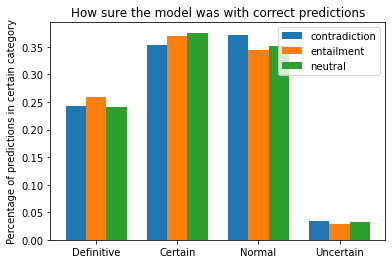

In [38]:
# Certainty if choice was correct
certainty
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

y = certainty[0]
z = certainty[1]
k = certainty[2]
# k = [11, 12, 13]


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y, width, label=labels[0])
rects2 = ax.bar(x, z, width, label=labels[1])
rects2 = ax.bar(x + width, k, width, label=labels[2])

ax.set_ylabel('Percentage of predictions in certain category')
ax.set_title('How sure the model was with correct predictions')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

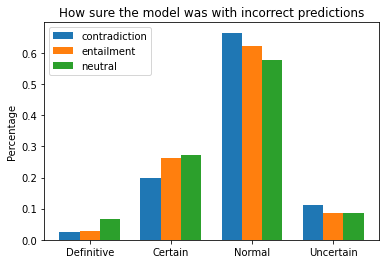

In [40]:
# Certainty if choice was correct
certainty_incorrect
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

y = certainty_incorrect[0]
z = certainty_incorrect[1]
k = certainty_incorrect[2]
# k = [11, 12, 13]


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y, width, label=labels[0])
rects2 = ax.bar(x, z, width, label=labels[1])
rects2 = ax.bar(x + width, k, width, label=labels[2])

ax.set_ylabel('Percentage')
ax.set_title('How sure the model was with incorrect predictions')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

# Bert

In [41]:
# import keras
# from keras import datasets, layers, models

# import tensorflow as tf
# import transformers

# max_length = 128  # Maximum length of input sentence to the model.
# batch_size = 256
# epochs = 30

# def create_bert_model():
#     # Encoded token ids from BERT tokenizer.
#     input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
#     # Attention masks indicates to the model which tokens should be attended to.
#     attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
#     # Token type ids are binary masks identifying different sequences in the model.
# #     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    
#     bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=False)
#     bert_model.trainable = False

#     sequence_output = bert_model(input_ids, attention_mask=attention_masks)
    
#     y_1= layers.Dense(300,activation='tanh')(sequence_output[0])
#     y_2= layers.Dense(300,activation='tanh')(y_1)
#     y_3= layers.Dense(300,activation='tanh')(y_2)

#     output=layers.Flatten()(y_3)
#     output = layers.Dense(3, activation='softmax')(output)

#     model = keras.models.Model([input_ids, attention_masks], output)
#     model.summary()
#     return model

In [42]:
# bert = create_bert_model()
# bert.load_weights('bert_300000_40/bert_weights_300000_40epochs.hdf5')
# bert.summary()

In [43]:
# tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)
# sentence_pairs_test = test_df[['premise', 'hypothesis']].values.astype('str')


# encoded_test = tokenizer.batch_encode_plus(
#     sentence_pairs_test.tolist(),
#     add_special_tokens=True,
#     max_length=max_length,
#     return_attention_mask=True,
#     return_token_type_ids=True,
#     pad_to_max_length=True,
#     return_tensors="tf")

# input_ids = np.array(encoded_test["input_ids"], dtype="int32")
# attention_masks = np.array(encoded_test["attention_mask"], dtype="int32")
# token_type_ids = np.array(encoded_test["token_type_ids"], dtype="int32")

# test_pred = bert.predict([input_ids, attention_masks], batch_size=batch_size)

In [44]:
# predictions_bert = pd.read_csv("Bert_test_results.csv")
predictions_bert = pd.read_csv("bert_300000_40/Bert_test_results_300000_40epochs.csv")
predictions_bert = predictions_bert.drop(columns='Unnamed: 0')
predictions_bert = predictions_bert.to_numpy()

In [45]:
predictions_bert.shape

(9824, 3)

In [48]:
bert_pred_name = convert_to_label_names(predictions_bert)
gold_label_names = convert_to_label_names(enc_gold_label_test)

[3257 3450 3117]
['contradiction', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']
[3237 3368 3219]
['neutral', 'entailment', 'contradiction', 'neutral', 'entailment', 'contradiction', 'entailment', 'neutral', 'contradiction', 'neutral']


In [49]:
correct = 0
total = 0
for i,l in zip(bert_pred_name, gold_label_names):
    if i == l:
        correct +=1
    total +=1

In [50]:
#accuracy for all sentences, 20 epochs:
correct/total

0.6107491856677525

In [51]:
from collections import Counter, defaultdict
# counter of incorrectly predicted tags
incorrect_tags = defaultdict(lambda: defaultdict(list))
# counter of tags that have been confused with each other
confused_tags = defaultdict(lambda: defaultdict(list))
predicted_tags = defaultdict(lambda: defaultdict(list))
prob_of_correct_tag = defaultdict(lambda: defaultdict(list))
all_probs = defaultdict(lambda: defaultdict(list))

predicted_percentage = np.max(predictions_bert, axis=1)
# print(all_tags['neutral'])
for sentence_idx in range(len(bert_pred_name)):
    pred = bert_pred_name[sentence_idx]
    correct = gold_label_name[sentence_idx]
    percentage = predicted_percentage[sentence_idx]
    
    if correct == 'contradiction':
        percentage_correct = predictions_bert[sentence_idx][0]
    elif correct == 'entailment':
        percentage_correct = predictions_bert[sentence_idx][1]
    elif correct == 'neutral':
        percentage_correct = predictions_bert[sentence_idx][2]
    
    predicted_tags[pred][correct].append(percentage)
    prob_of_correct_tag[pred][correct].append(percentage_correct)
    all_probs['contradiction'][correct].append(predictions_bert[sentence_idx][0])
    all_probs['entailment'][correct].append(predictions_bert[sentence_idx][1])
    all_probs['neutral'][correct].append(predictions_bert[sentence_idx][2])
    

In [52]:
labels = ['contradiction', 'entailment', 'neutral']
for l in labels:
    for m in labels:
        items = np.array(predicted_tags[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min())
        items = np.array(prob_of_correct_tag[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min(),"Probs of correct prediction")

Predicted: contradiction Correct: contradiction Max: 0.9520950999999999 Mean: 0.6055649163995943 Min: 0.34233683
Predicted: contradiction Correct: contradiction Max: 0.9520950999999999 Mean: 0.6055649163995943 Min: 0.34233683 Probs of correct prediction
Predicted: contradiction Correct: entailment Max: 0.94668627 Mean: 0.5155408768674699 Min: 0.3454337
Predicted: contradiction Correct: entailment Max: 0.45249853 Mean: 0.23418041991967872 Min: 0.015015172 Probs of correct prediction
Predicted: contradiction Correct: neutral Max: 0.8817415999999999 Mean: 0.5322113731385006 Min: 0.3420229
Predicted: contradiction Correct: neutral Max: 0.48754877 Mean: 0.2986404682858958 Min: 0.06605035 Probs of correct prediction
Predicted: entailment Correct: contradiction Max: 0.9277605999999999 Mean: 0.5341193520274914 Min: 0.33772179999999996
Predicted: entailment Correct: contradiction Max: 0.44560406 Mean: 0.2370068289209622 Min: 0.025963522000000003 Probs of correct prediction
Predicted: entailment

In [53]:
labels = ['contradiction', 'entailment', 'neutral']
certainty_bert = []
certainty_bert_incorrect = []
for l in labels:
    for m in labels:
        items = np.array(predicted_tags[l][m])
        print("Predicted:", l,"Correct:", m,"Max:", items.max(), "Mean:", items.mean(), "Min:", items.min())
        definitive = items[items>=0.8]
        certain = items[np.logical_and(items<0.8, items>=0.6)]
        normal = items[np.logical_and(items<0.6, items>=0.4)]
#         relatively_uncertain = items[np.logical_and(items<0.4, items>=0.2)]
        uncertain = items[items<0.4]
        print("Definitive:", len(definitive)/len(items), "Certain:", len(certain)/len(items), "Normal:", len(normal)/len(items), "Uncertain:", len(uncertain)/len(items))
        print("")
        if l == m:
            certainty_bert.append([len(definitive)/len(items),len(certain)/len(items),len(normal)/len(items),len(uncertain)/len(items)])
        else:
            certainty_bert_incorrect.append([len(definitive)/len(items),len(certain)/len(items),len(normal)/len(items),len(uncertain)/len(items)])

Predicted: contradiction Correct: contradiction Max: 0.9520950999999999 Mean: 0.6055649163995943 Min: 0.34233683
Definitive: 0.09127789046653144 Certain: 0.38742393509127787 Normal: 0.4787018255578093 Uncertain: 0.04259634888438134

Predicted: contradiction Correct: entailment Max: 0.94668627 Mean: 0.5155408768674699 Min: 0.3454337
Definitive: 0.014056224899598393 Certain: 0.20281124497991967 Normal: 0.6485943775100401 Uncertain: 0.13453815261044177

Predicted: contradiction Correct: neutral Max: 0.8817415999999999 Mean: 0.5322113731385006 Min: 0.3420229
Definitive: 0.01905972045743329 Certain: 0.2121982210927573 Normal: 0.7013977128335451 Uncertain: 0.06734434561626429

Predicted: entailment Correct: contradiction Max: 0.9277605999999999 Mean: 0.5341193520274914 Min: 0.33772179999999996
Definitive: 0.02577319587628866 Certain: 0.24398625429553264 Normal: 0.6408934707903781 Uncertain: 0.08934707903780069

Predicted: entailment Correct: entailment Max: 0.9800136 Mean: 0.6160338541756273

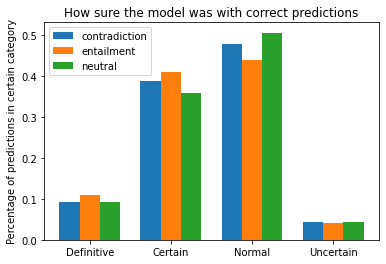

In [54]:
# Certainty if choice was correct
certainty_bert
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

y = certainty_bert[0]
z = certainty_bert[1]
k = certainty_bert[2]
# k = [11, 12, 13]


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y, width, label=labels[0])
rects2 = ax.bar(x, z, width, label=labels[1])
rects2 = ax.bar(x + width, k, width, label=labels[2])

ax.set_ylabel('Percentage of predictions in certain category')
ax.set_title('How sure the model was with correct predictions')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

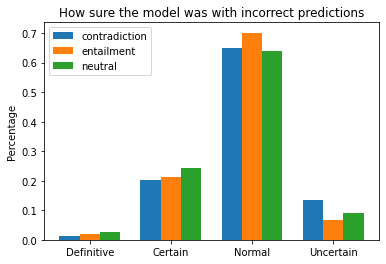

In [55]:
# Certainty if choice was correct
certainty_bert_incorrect
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

y = certainty_bert_incorrect[0]
z = certainty_bert_incorrect[1]
k = certainty_bert_incorrect[2]
# k = [11, 12, 13]


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, y, width, label=labels[0])
rects2 = ax.bar(x, z, width, label=labels[1])
rects2 = ax.bar(x + width, k, width, label=labels[2])

ax.set_ylabel('Percentage')
ax.set_title('How sure the model was with incorrect predictions')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

# Compare different models

In [56]:
print("Generate predictions for test")
predictions = new_model.predict([sentence_embs_prem_test, sentence_embs_hyp_test])
print("predictions shape:", predictions.shape)

Generate predictions for test
predictions shape: (9824, 3)


In [57]:
print("Generate predictions for test")
# predictions_second = second_baseline.predict([sentence_embs_prem_test, sentence_embs_hyp_test])
print("predictions shape:", predictions_elmo.shape)

Generate predictions for test
predictions shape: (9824, 3)


In [58]:
predicted_label_model1 = convert_to_label_names(predictions)
predicted_label_model2 = convert_to_label_names(predictions_elmo)
predicted_label_bert = convert_to_label_names(predictions_bert)
gold_label_names = convert_to_label_names(enc_gold_label_test)

[3047 3461 3316]
['contradiction', 'contradiction', 'contradiction', 'entailment', 'neutral', 'entailment', 'entailment', 'contradiction', 'contradiction', 'entailment']
[3141 3567 3116]
['entailment', 'entailment', 'contradiction', 'neutral', 'neutral', 'entailment', 'entailment', 'neutral', 'entailment', 'neutral']
[3257 3450 3117]
['contradiction', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']
[3237 3368 3219]
['neutral', 'entailment', 'contradiction', 'neutral', 'entailment', 'contradiction', 'entailment', 'neutral', 'contradiction', 'neutral']


# Classification Report

In [59]:
from sklearn.metrics import classification_report
print("Baseline")
target_names = labels
print(classification_report(gold_label_names, predicted_label_model1, target_names=target_names, digits=4))
print("Elmo")
print(classification_report(gold_label_names, predicted_label_model2, target_names=target_names, digits=4))
print("Bert")
print(classification_report(gold_label_names, predicted_label_bert, target_names=target_names, digits=4))

Baseline
               precision    recall  f1-score   support

contradiction     0.5484    0.5162    0.5318      3237
   entailment     0.5649    0.5805    0.5726      3368
      neutral     0.5492    0.5657    0.5573      3219

     accuracy                         0.5545      9824
    macro avg     0.5541    0.5541    0.5539      9824
 weighted avg     0.5543    0.5545    0.5541      9824

Elmo
               precision    recall  f1-score   support

contradiction     0.6119    0.5938    0.6027      3237
   entailment     0.6459    0.6841    0.6645      3368
      neutral     0.6425    0.6219    0.6320      3219

     accuracy                         0.6340      9824
    macro avg     0.6334    0.6333    0.6331      9824
 weighted avg     0.6336    0.6340    0.6335      9824

Bert
               precision    recall  f1-score   support

contradiction     0.6055    0.6092    0.6073      3237
   entailment     0.6470    0.6627    0.6547      3368
      neutral     0.5762    0.5579    0

In [60]:
from sklearn.metrics import accuracy_score
print("Baseline")
target_names = labels
print(accuracy_score(gold_label_names, predicted_label_model1))
print("Elmo")
print(accuracy_score(gold_label_names, predicted_label_model2))
print("Bert")
print(accuracy_score(gold_label_names, predicted_label_bert))

Baseline
0.5544584690553745
Elmo
0.633957654723127
Bert
0.6107491856677525


In [61]:
labels

['contradiction', 'entailment', 'neutral']

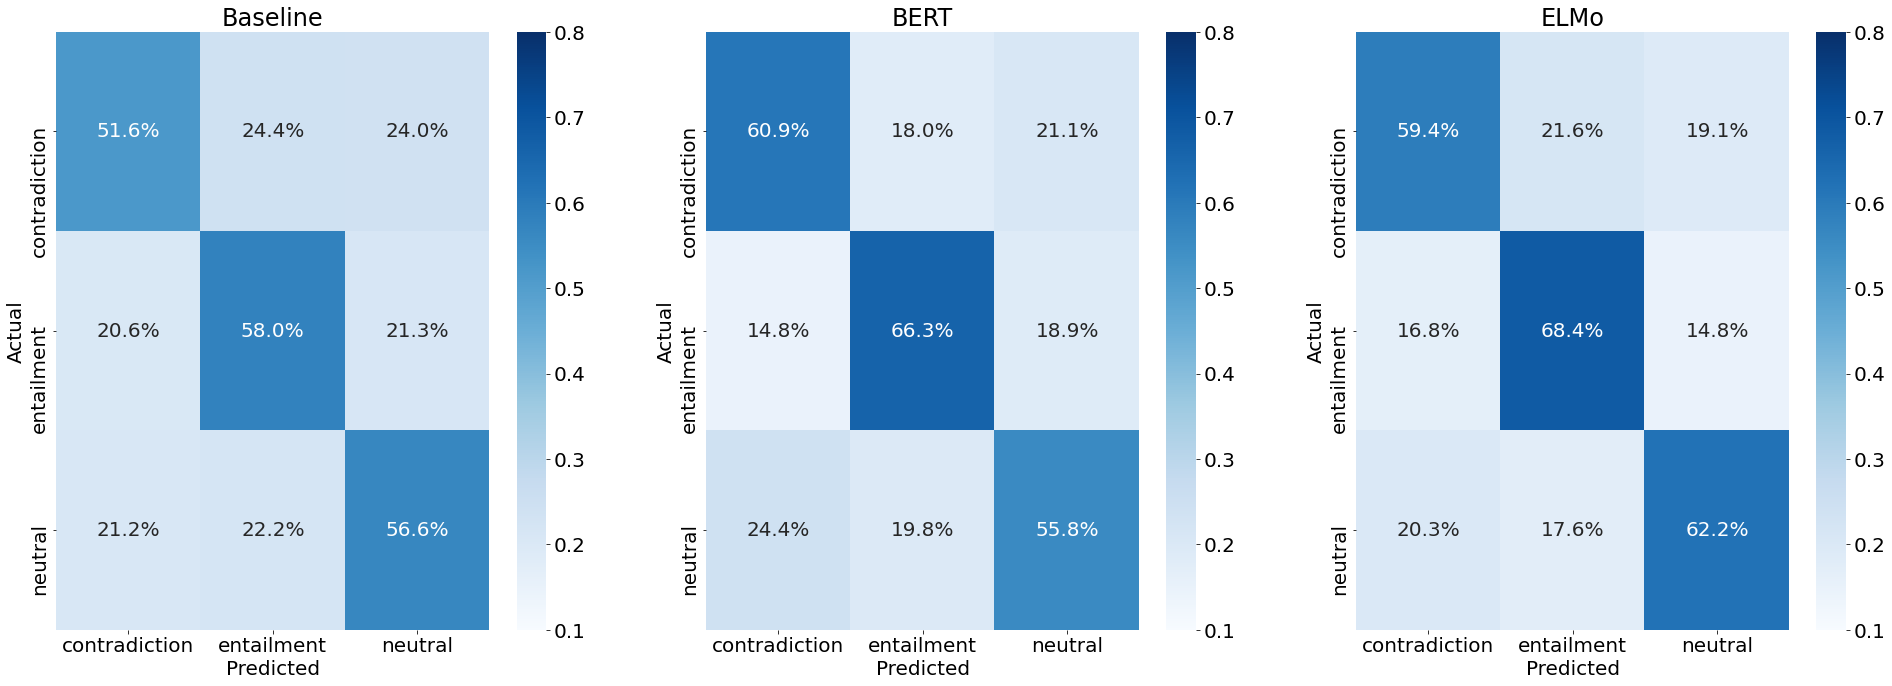

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
p = [predicted_label_model1, predicted_label_bert,predicted_label_model2]
titles = ["Baseline", "BERT", "ELMo"]
fig, axs = plt.subplots(ncols=3,figsize =(33, 11))
for i,ax in enumerate(axs):
    cf_matrix = confusion_matrix(gold_label_names, p[i], labels=labels)
    cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
    # f = plt.figure(figsize=(11,11))
    # ax= plt.subplot()

    sns.heatmap(cf_matrix/cm_sum, annot=True, ax=ax, fmt='0.1%', vmin=0.1, vmax=0.8,cmap='Blues',xticklabels=labels, yticklabels=labels) #annot=True to annotate cells
    ax.set_title(titles[i])
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
# plt.show()
plt.savefig("Confusion Matrices.png")
# cf_matrix = confusion_matrix(gold_label_names, predicted_label_model2, labels=labels)
# cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
# # f = plt.figure(figsize=(11,11))
# # ax= plt.subplot()
# sns.heatmap(cf_matrix/cm_sum, annot=True, ax=ax[1], fmt='0.1%', cmap='Blues',xticklabels=labels, yticklabels=labels) #annot=True to annotate cells
# # plt.show()

# cf_matrix = confusion_matrix(gold_label_names, predicted_label_bert, labels=labels)
# cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
# # f = plt.figure(figsize=(11,11))
# # ax= plt.subplot()
# sns.heatmap(cf_matrix/cm_sum, annot=True, ax=[2], fmt='0.1%', cmap='Blues',xticklabels=labels, yticklabels=labels) #annot=True to annotate cells
# # plt.show()

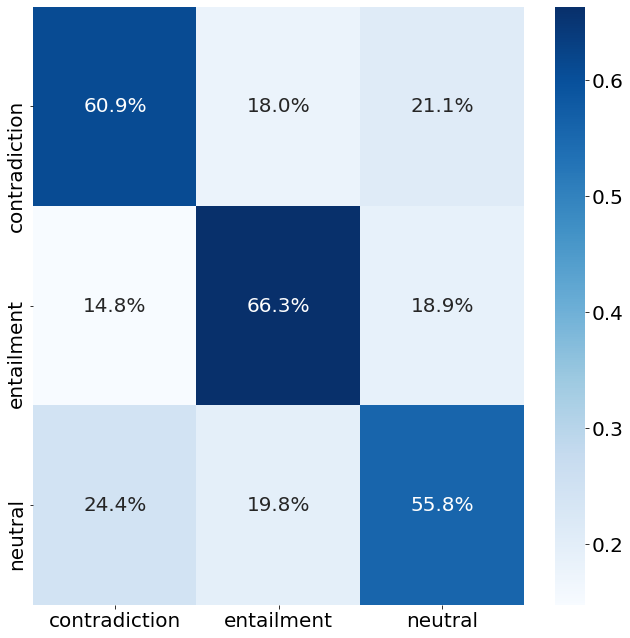

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(gold_label_names, predicted_label_bert, labels=labels)
cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
f = plt.figure(figsize=(11,11))
ax= plt.subplot()
sns.heatmap(cf_matrix/cm_sum, annot=True, ax=ax, fmt='0.1%', cmap='Blues',xticklabels=labels, yticklabels=labels) #annot=True to annotate cells
plt.show()

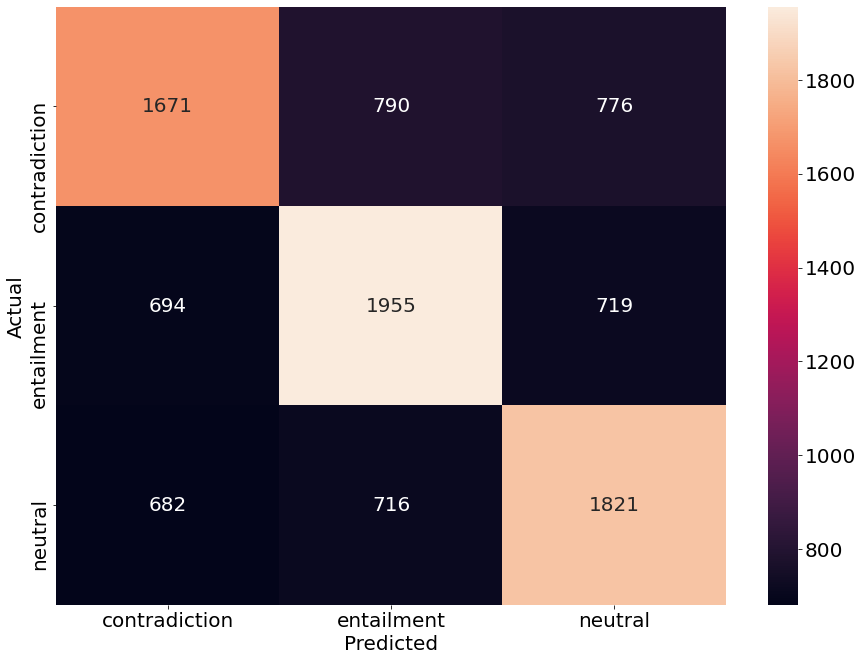

In [64]:
import seaborn as sns
# confusion matrix
d = {'y_predicted':predicted_label_model1,'y_true':gold_label_names}
ink_corr_df = pd.DataFrame(d)

confusion_matrix = pd.crosstab(ink_corr_df['y_true'], ink_corr_df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
f = plt.figure(figsize=(15, 11))
sns.heatmap(confusion_matrix, annot=True,fmt='d')
# plt.show()
plt.savefig('conf_matrix_baseline_model.png')

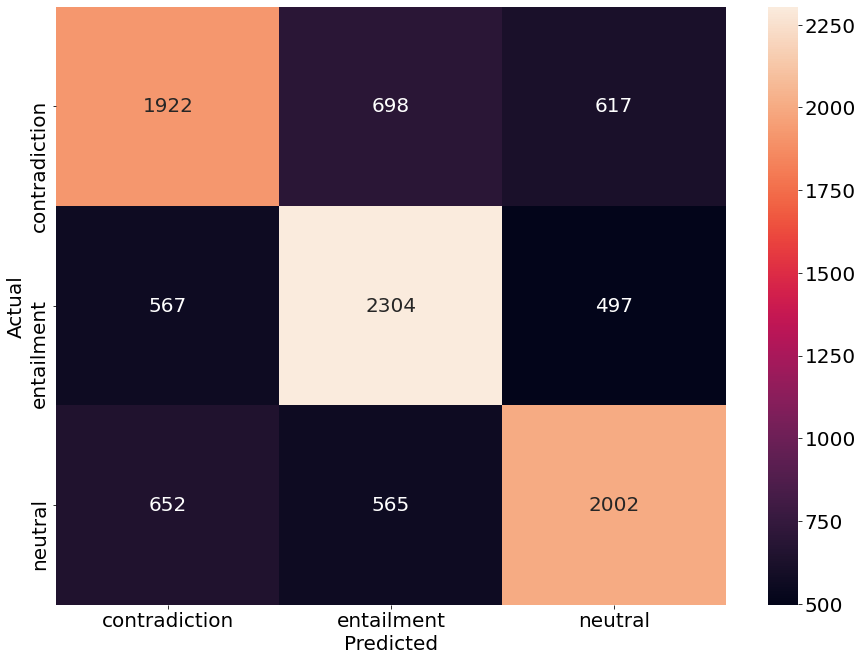

In [65]:
import seaborn as sns
# confusion matrix
d = {'y_predicted':predicted_label_model2,'y_true':gold_label_names}
ink_corr_df = pd.DataFrame(d)

confusion_matrix = pd.crosstab(ink_corr_df['y_true'], ink_corr_df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
f = plt.figure(figsize=(15, 11))
sns.heatmap(confusion_matrix, annot=True,fmt='d')
# plt.show()
plt.savefig('conf_matrix_elmo_model.png')

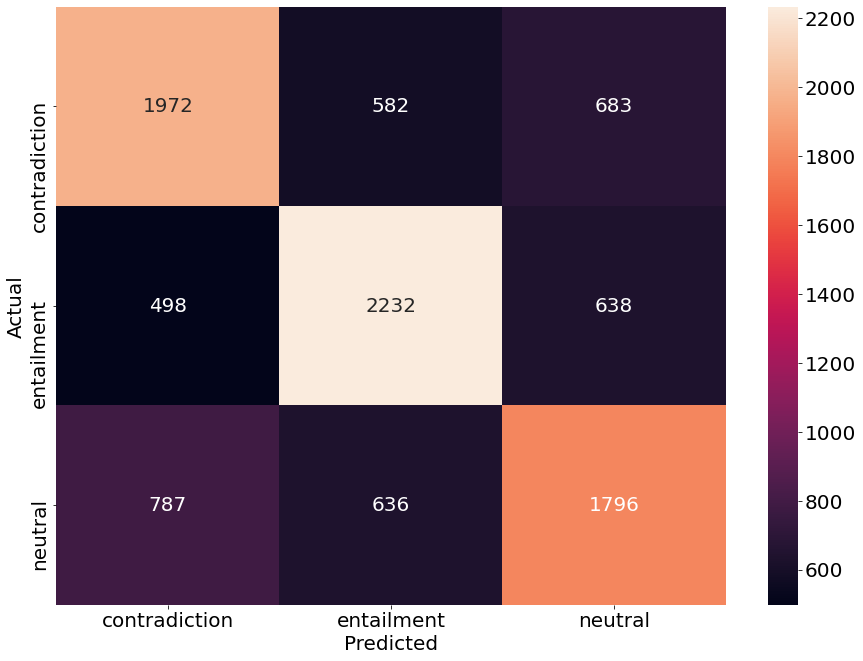

In [66]:
import seaborn as sns
# confusion matrix
d = {'y_predicted':predicted_label_bert,'y_true':gold_label_names}
ink_corr_df = pd.DataFrame(d)

confusion_matrix = pd.crosstab(ink_corr_df['y_true'], ink_corr_df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
f = plt.figure(figsize=(15, 11))
sns.heatmap(confusion_matrix, annot=True,fmt='d')
# plt.show()
plt.savefig('conf_matrix_bert_model.png')

# Heatmap comparing both models

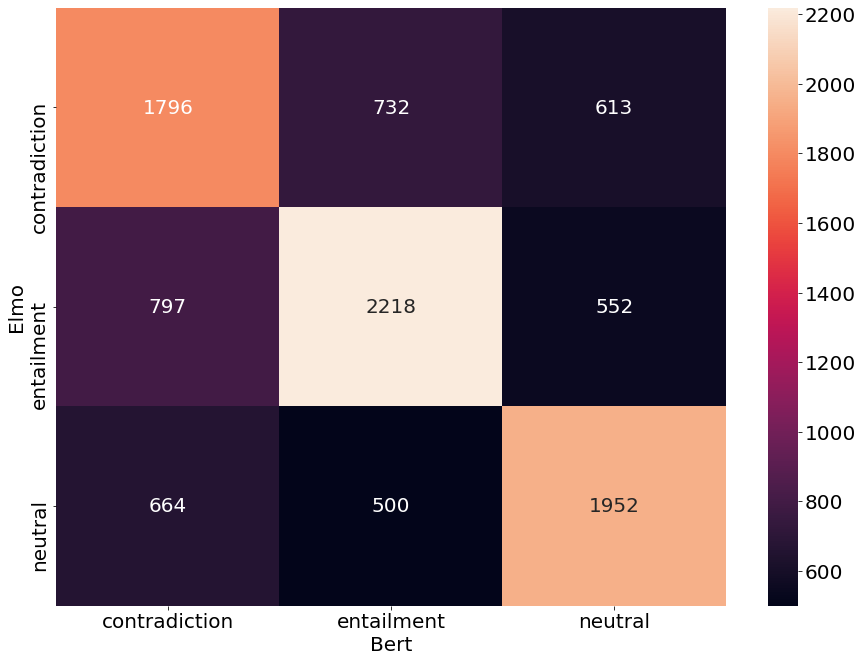

In [67]:
import seaborn as sns
# confusion matrix
d = {'bert_pred':predicted_label_bert,'elmo_pred':predicted_label_model2}
confusion = pd.DataFrame(d)

confusion_matrix = pd.crosstab(confusion['elmo_pred'], confusion['bert_pred'], rownames=['Elmo'], colnames=['Bert'])
f = plt.figure(figsize=(15, 11))
sns.heatmap(confusion_matrix, annot=True,fmt='d')
# plt.show()
plt.savefig('conf_matrix_elmo_bert_model.png')

## Heatmap comparing wrong predictions of both models

In [68]:
predicted_label_model1_wrong = []
predicted_label_model2_wrong = []
predicted_label_bert_wrong = []
for i,j,k, l in zip(predicted_label_model1, predicted_label_model2, predicted_label_bert, gold_label_names):
    if k != l and j != l:
#         predicted_label_model1_wrong.append(i)
        predicted_label_model2_wrong.append(j)
        predicted_label_bert_wrong.append(k)

In [69]:
len(predicted_label_model2_wrong)

2091

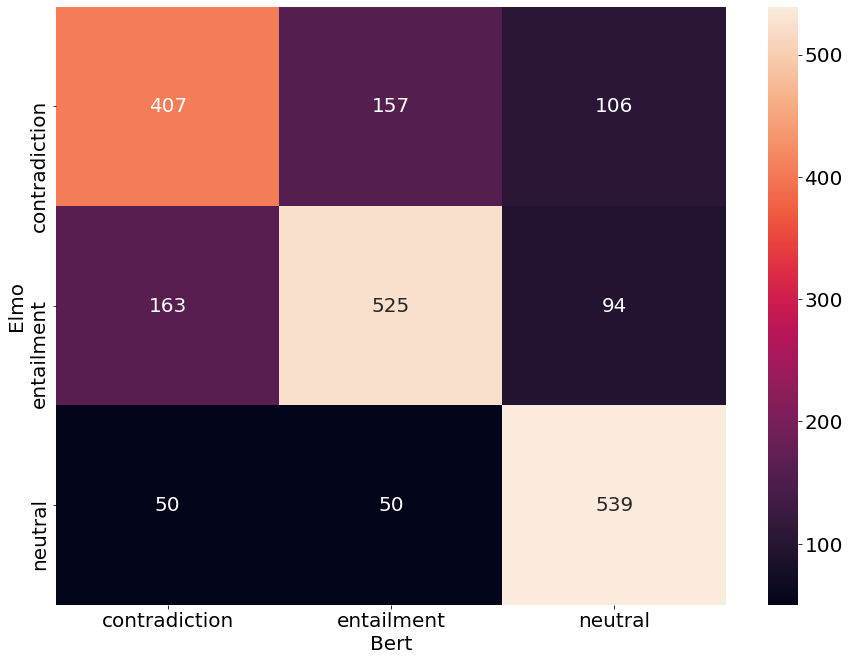

In [70]:
import seaborn as sns
# confusion matrix
d = {'bert_pred':predicted_label_bert_wrong,'elmo_pred':predicted_label_model2_wrong}
confusion = pd.DataFrame(d)

confusion_matrix = pd.crosstab(confusion['elmo_pred'], confusion['bert_pred'], rownames=['Elmo'], colnames=['Bert'])
f = plt.figure(figsize=(15, 11))
sns.heatmap(confusion_matrix, annot=True,fmt='d')
# plt.show()
plt.savefig('conf_matrix_elmo_model.png')

In [71]:
incorrect_tags = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) #list of tags that is incorrect (return id)
all_tags = defaultdict(lambda: defaultdict(Counter)) #Counter for each label which model did how well
diff_tags = defaultdict(lambda: defaultdict(lambda: defaultdict(Counter)))
diff_tags_sentences = defaultdict((lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

# both_incorrect_tags = defaultdict(lambda: defaultdict(Counter))
# both_incorrect_tag_sentences = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

model1_name = "Baseline"
model2_name = "Elmo"
bert_name = "Bert"
model1_correct = "Baseline Correct"
model2_correct = "Elmo Correct"
bert_correct = "Bert Correct"


for i in range(len(gold_label_names)):
    model1 = predicted_label_model1[i]
    model2 = predicted_label_model2[i]
    bert = predicted_label_bert[i]
    gold_label = gold_label_names[i]
    model1_incorrect = False
    model2_incorrect = False
    bert_incorrect = False
    all_tags[model1_name][gold_label][model1] += 1
    all_tags[model2_name][gold_label][model2] += 1
    all_tags[bert_name][gold_label][bert] += 1
    
    #TODO add bert model to the rest
    if model1 != gold_label:
        model1_incorrect = True
        incorrect_tags[model1_name][gold_label][model1].append(i)
    if model2 != gold_label:
        model2_incorrect = True
        incorrect_tags[model2_name][gold_label][model2].append(i)
    if bert != gold_label:
        bert_incorrect = True
        incorrect_tags[bert_name][gold_label][bert].append(i)
        
    difference_type = ""
    if not model1_incorrect and not model2_incorrect and not bert_incorrect:
        difference_type = "all correct"
    elif not model1_incorrect and not model2_incorrect and bert_incorrect:
        difference_type = "only bert incorrect"
    elif not model1_incorrect and model2_incorrect and not bert_incorrect:
        difference_type = "only elmo incorrect"
    elif not model1_incorrect and model2_incorrect and bert_incorrect:
        difference_type = "bert and elmo incorrect"
        
    elif model1_incorrect and not model2_incorrect and not bert_incorrect:
        difference_type = "only baseline incorrect"
    elif model1_incorrect and not model2_incorrect and bert_incorrect:
        difference_type = "baseline and bert incorrect"
        
    elif model1_incorrect and model2_incorrect and not bert_incorrect:
        difference_type = "baseline and elmo incorrect"
    elif model1_incorrect and model2_incorrect and bert_incorrect:
        difference_type = "all incorrect"
    
    diff_tags[difference_type][model1][model2][bert] +=1
    diff_tags_sentences[difference_type][model1][model2][bert].append(i)


In [72]:
diff_tags

defaultdict(<function __main__.<lambda>()>,
            {'all incorrect': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'contradiction': defaultdict(collections.Counter,
                                      {'entailment': Counter({'contradiction': 39,
                                                'entailment': 33}),
                                       'contradiction': Counter({'contradiction': 243,
                                                'entailment': 80,
                                                'neutral': 46}),
                                       'neutral': Counter({'contradiction': 9,
                                                'neutral': 27})}),
                          'neutral': defaultdict(collections.Counter,
                                      {'neutral': Counter({'neutral': 384,
                                                'contradiction': 30,
                                                'entailment

# Plot accuracy for each label

In [73]:
all_tags

defaultdict(<function __main__.<lambda>()>,
            {'Baseline': defaultdict(collections.Counter,
                         {'neutral': Counter({'contradiction': 682,
                                   'entailment': 716,
                                   'neutral': 1821}),
                          'entailment': Counter({'contradiction': 694,
                                   'neutral': 719,
                                   'entailment': 1955}),
                          'contradiction': Counter({'contradiction': 1671,
                                   'entailment': 790,
                                   'neutral': 776})}),
             'Elmo': defaultdict(collections.Counter,
                         {'neutral': Counter({'entailment': 565,
                                   'neutral': 2002,
                                   'contradiction': 652}),
                          'entailment': Counter({'entailment': 2304,
                                   'neutral': 497,
         

In [74]:
elmo_correct = []
baseline_correct = []
bert_correct = []
for i in labels:
    elmo_correct.append(all_tags['Elmo'][i][i])
    baseline_correct.append(all_tags['Baseline'][i][i])
    bert_correct.append(all_tags['Bert'][i][i])

In [75]:
print(labels)
print(elmo_correct)

['contradiction', 'entailment', 'neutral']
[1922, 2304, 2002]


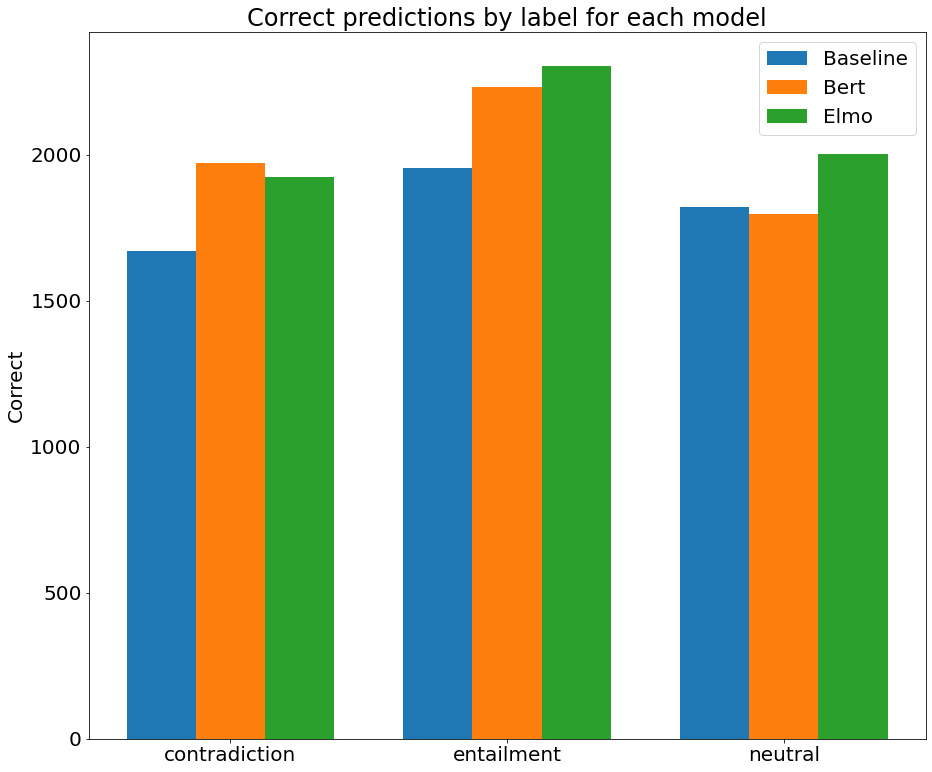

In [78]:
# x = labels

y = baseline_correct
z = elmo_correct
# k = [11, 12, 13]
k = bert_correct

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,13))
rects1 = ax.bar(x - width, baseline_correct, width, label='Baseline')
rects1 = ax.bar(x, bert_correct, width, label='Bert')
rects2 = ax.bar(x + width, elmo_correct, width, label='Elmo')

ax.set_ylabel('Correct')
ax.set_title('Correct predictions by label for each model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [79]:
elmo_correct = []
baseline_correct = []
for i in labels:
    elmo_correct.append(all_tags['Elmo'][i][i])
    baseline_correct.append(all_tags['Baseline'][i][i])

# How sure are the models with predictions

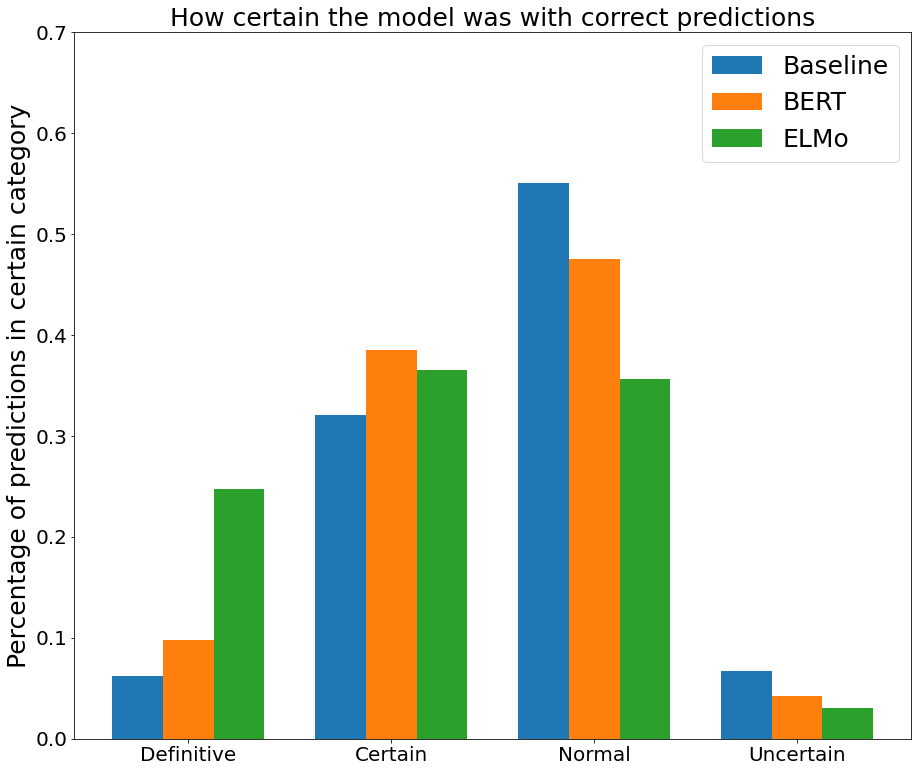

In [80]:
# Certainty if choice was correct
certainty_elmo = np.array(certainty)
certainty_baseline = np.array(certainty_baseline)
certainty_bert = np.array(certainty_bert)
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

baseline = certainty_baseline.mean(axis=0)
bert = certainty_bert.mean(axis=0)
elmo = certainty_elmo.mean(axis=0)


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,13))
rects1 = ax.bar(x - width, baseline, width, label="Baseline")
rects2 = ax.bar(x, bert, width, label="BERT")
rects2 = ax.bar(x + width, elmo, width, label="ELMo")

ax.set_ylabel('Percentage of predictions in certain category', fontsize=25)
ax.set_title('How certain the model was with correct predictions', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=20)
# ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6] , Fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
# ax.set_ytick(Fontsize=25)
ax.legend(fontsize=25)
ax.set_ylim(0,0.7)
# definitive: X>=0.8
# certain: 0.6<=X<0.8
# normal: 0.4<=X<0.6
# uncertain: X<0.4
# plt.xticks(fontsize=25)

# plt.show()
plt.savefig("Certainty_correct_predictions.png")
# shows that for elmo almost 60% of the correct predictions had a probability of over 80% for that label
# for Baseline only 5% of the correct predictions were that "sure" that it was correct

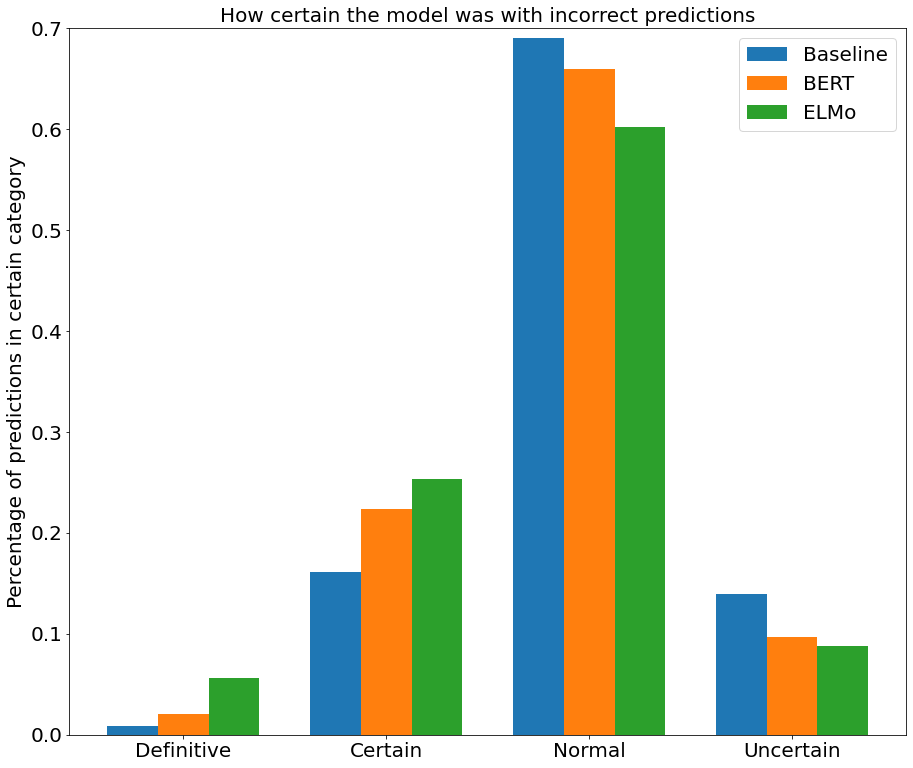

In [81]:
# Certainty if choice was incorrect
certainty_elmo_incorrect = np.array(certainty_incorrect)
certainty_baseline_incorrect = np.array(certainty_baseline_incorrect)
certainty_bert_incorrect = np.array(certainty_bert_incorrect)
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

baseline = certainty_baseline_incorrect.mean(axis=0)
bert = certainty_bert_incorrect.mean(axis=0)
elmo = certainty_elmo_incorrect.mean(axis=0)
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,13))
rects1 = ax.bar(x - width, baseline, width, label="Baseline")
rects2 = ax.bar(x, bert, width, label="BERT")
rects2 = ax.bar(x + width, elmo, width, label="ELMo")

ax.set_ylabel('Percentage of predictions in certain category', fontsize=20)
ax.set_title('How certain the model was with incorrect predictions', fontsize=20)
ax.set_xticks(x)
ax.set_ylim(0,0.7)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_xticklabels(categories, fontsize=20)
ax.legend(fontsize=20)
plt.savefig("Certainty_incorrect_predictions.png")

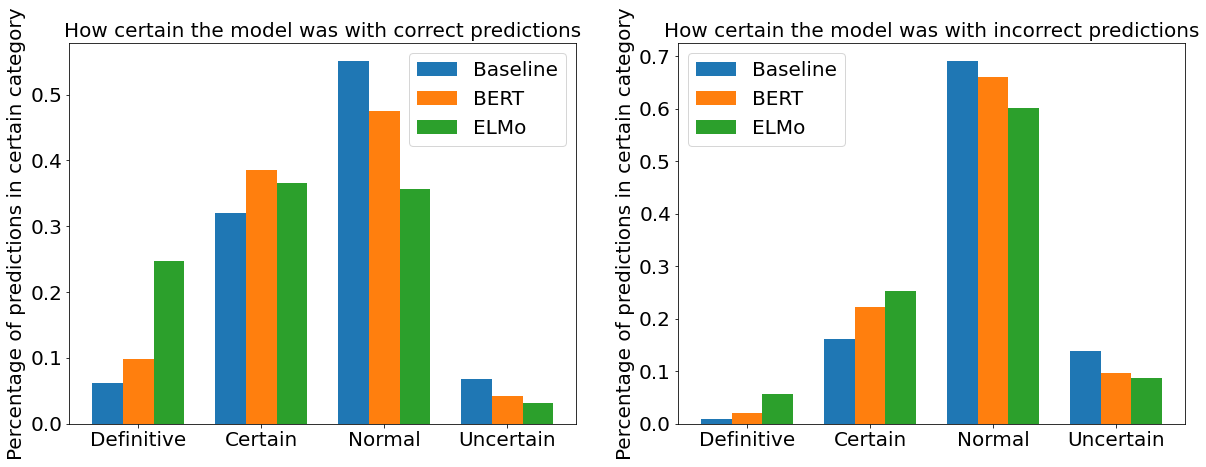

In [82]:
# Certainty if choice was incorrect
certainty_elmo_incorrect = np.array(certainty_incorrect)
certainty_baseline_incorrect = np.array(certainty_baseline_incorrect)
certainty_bert_incorrect = np.array(certainty_bert_incorrect)
categories = ["Definitive", "Certain", "Normal", "Uncertain"]

baseline = certainty_baseline_incorrect.mean(axis=0)
bert = certainty_bert_incorrect.mean(axis=0)
elmo = certainty_elmo_incorrect.mean(axis=0)


x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, axs = plt.subplots(ncols=2, figsize=(20,7))
for i,ax in enumerate(axs):
    if i ==1:
        baseline = certainty_baseline_incorrect.mean(axis=0)
        bert = certainty_bert_incorrect.mean(axis=0)
        elmo = certainty_elmo_incorrect.mean(axis=0)
        rects1 = ax.bar(x - width, baseline, width, label="Baseline")
        rects2 = ax.bar(x, bert, width, label="BERT")
        rects2 = ax.bar(x + width, elmo, width, label="ELMo")

        ax.set_ylabel('Percentage of predictions in certain category', fontsize=20)
        ax.set_title('How certain the model was with incorrect predictions', fontsize=20)
        ax.set_xticks(x)
        ax.tick_params(axis='y', which='major', labelsize=20)
        ax.set_xticklabels(categories, fontsize=20)
        ax.legend(fontsize=20)
    if i==0:
        baseline = certainty_baseline.mean(axis=0)
        bert = certainty_bert.mean(axis=0)
        elmo = certainty_elmo.mean(axis=0)
        rects1 = ax.bar(x - width, baseline, width, label="Baseline")
        rects2 = ax.bar(x, bert, width, label="BERT")
        rects2 = ax.bar(x + width, elmo, width, label="ELMo")

        ax.set_ylabel('Percentage of predictions in certain category', fontsize=20)
        ax.set_title('How certain the model was with correct predictions', fontsize=20)
        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=20)
        # ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6] , Fontsize=25)
        ax.tick_params(axis='y', which='major', labelsize=20)
        # ax.set_ytick(Fontsize=25)
        ax.legend(fontsize=20)
# definitive: X>=0.8
# certain: 0.6<=X<0.8
# normal: 0.4<=X<0.6
# uncertain: X<0.4

# plt.show()
plt.savefig("Certainty_of_predictions.png")

# History

In [87]:
history_baseline = pd.read_csv("baseline_history_300000_40epochs.csv")
history_elmo = pd.read_csv("elmo_300000_40/history_300000_40epochs.csv")
history_bert = pd.read_csv("bert_300000_40/bert_history_300000_40epochs.csv")

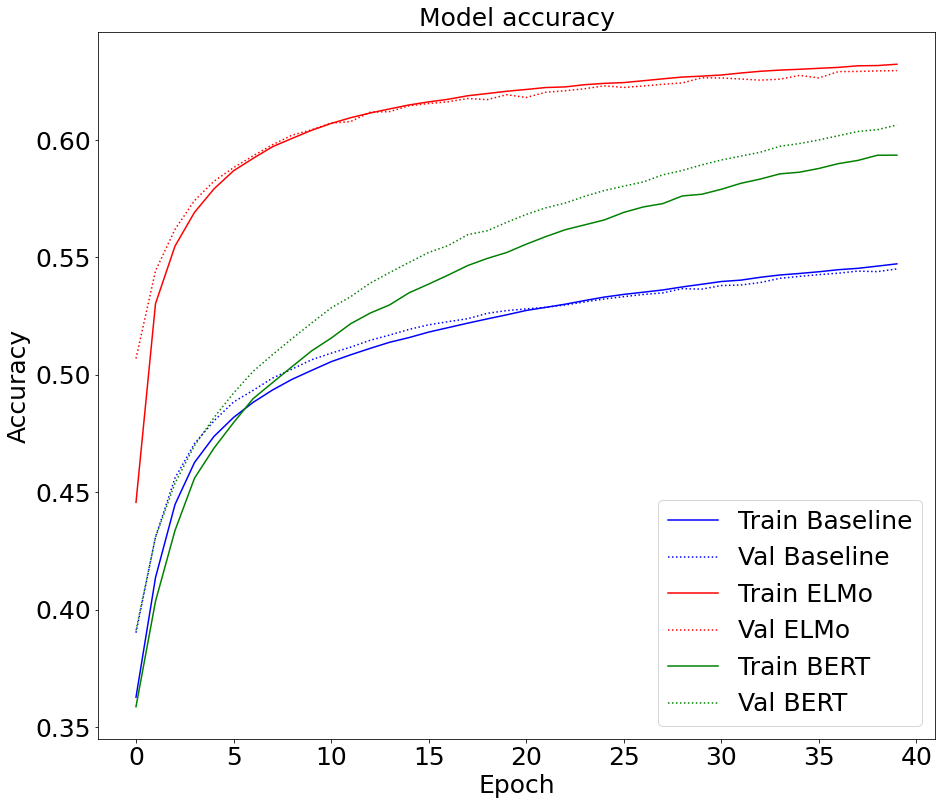

In [88]:
plt.figure(figsize=(15,13))
plt.plot(history_baseline['accuracy'], color='blue')
plt.plot(history_baseline['val_accuracy'], color='blue', linestyle='dotted')
plt.plot(history_elmo['accuracy'], color='red')
plt.plot(history_elmo['val_accuracy'], color='red', linestyle='dotted')
plt.plot(history_bert['accuracy'], color='green')
plt.plot(history_bert['val_accuracy'], color='green', linestyle='dotted')

plt.title('Model accuracy', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xlabel('Epoch', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(['Train Baseline', 'Val Baseline','Train ELMo', 'Val ELMo','Train BERT', 'Val BERT'], loc='lower right', fontsize=25)
# plt.show()
plt.savefig("Comparison of accuracy during training")

# Sentences

In [92]:
premises_test = test_df['premise'].tolist()
hypothesis_test = test_df['hypothesis'].tolist()
gold_label_test = test_df['gold_label'].tolist()

In [93]:
diff_tags

defaultdict(<function __main__.<lambda>()>,
            {'all incorrect': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'contradiction': defaultdict(collections.Counter,
                                      {'entailment': Counter({'contradiction': 39,
                                                'entailment': 33}),
                                       'contradiction': Counter({'contradiction': 243,
                                                'entailment': 80,
                                                'neutral': 46}),
                                       'neutral': Counter({'contradiction': 9,
                                                'neutral': 27})}),
                          'neutral': defaultdict(collections.Counter,
                                      {'neutral': Counter({'neutral': 384,
                                                'contradiction': 30,
                                                'entailment

# All guessed the same incorrect value

In [94]:
# all incorrect
labels = ['contradiction', 'entailment', 'neutral']
sentences_all_incorrect = []
unknown_indices = []
for model1_pred in labels:
    for model2_pred in labels:
        for model3_pred in labels:
            for i in diff_tags_sentences['all incorrect'][model1_pred][model2_pred][model3_pred][0:6]:
                sentences_all_incorrect.append([gold_label_test[i], premises_test[i], hypothesis_test[i], model1_pred, model2_pred, model3_pred])
for gold_label, premise, hypothesis, baseline_pred, elmo_pred, bert_pred in sentences_all_incorrect:
#     assert baseline_pred == gold_label
    if baseline_pred == elmo_pred and elmo_pred == bert_pred:
        print(premise, hypothesis)

        print("Correct:",gold_label, "Model Prediction:", elmo_pred)
        print()

A man in a black shirt overlooking bike maintenance. A man watches bike repairs.
Correct: entailment Model Prediction: contradiction

Two women walk down a sidewalk along a busy street in a downtown area. The women were walking downtown
Correct: entailment Model Prediction: contradiction

A bird is flapping its wings on the water. The duck is swimming in the lake.
Correct: neutral Model Prediction: contradiction

A man wearing a gray ball cap walks next to a redheaded woman wearing a long-sleeved blue jean shirt. The man is cold.
Correct: neutral Model Prediction: contradiction

Four adults eat while sitting on a tile floor. Two couples eat food on a kitchen floor.
Correct: neutral Model Prediction: contradiction

A girl holding a beverage points at a painting. The girl is drinking an alcoholic beverage.
Correct: neutral Model Prediction: contradiction

A man standing in front of a building on the phone as two men to the side pain on the side. a busy man stands with bodyguards
Correct:

# Only baseline is correct

In [95]:
labels = ['contradiction', 'entailment', 'neutral']
sentences_baseline_correct = []
unknown_indices = []
for model1_pred in labels:
    for model2_pred in labels:
        for model3_pred in labels:
            for i in diff_tags_sentences['bert and elmo incorrect'][model1_pred][model2_pred][model3_pred][0:3]:
                sentences_baseline_correct.append([gold_label_test[i], premises_test[i], hypothesis_test[i], model1_pred, model2_pred, model3_pred])
for gold_label, premise, hypothesis, baseline_pred, elmo_pred, bert_pred in sentences_baseline_correct:
    assert baseline_pred == gold_label
    if elmo_pred == bert_pred:
        print(premise, hypothesis)

        print("Correct:",gold_label, "Model Prediction:", elmo_pred)
        print()

One tan girl with a wool hat is running and leaning over an object, while another person in a wool hat is sitting on the ground. A boy runs into a wall
Correct: contradiction Model Prediction: entailment

A couple is eating outside at a table and he is pointing at something. A couple is eating inside at a table and he is pointing at something.
Correct: contradiction Model Prediction: entailment

A boy hits a tennis ball on a court. A girl is hitting the ball.
Correct: contradiction Model Prediction: entailment

These are young adults who seem to be working together to protect the plants surrounding the white pole. The adults are old
Correct: contradiction Model Prediction: neutral

A woman leans over a small fence to take a picture of a yellow flower. The flower is blue
Correct: contradiction Model Prediction: neutral

A woman teaching a ballet class composed of small children holding colourful scarves. A woman is teaching a ballet class composed of middle aged men holding white scarve

# Only baseline wrong

In [96]:
labels = ['contradiction', 'entailment']
sentences_baseline_incorrect = []
unknown_indices = []
for model1_pred in labels:
    for model2_pred in labels:
        for model3_pred in labels:
            for i in diff_tags_sentences['only baseline incorrect'][model1_pred][model2_pred][model3_pred][0:9]:
                sentences_baseline_incorrect.append([gold_label_test[i], premises_test[i], hypothesis_test[i], model1_pred, model2_pred, model3_pred])
for gold_label, premise, hypothesis, baseline_pred, elmo_pred, bert_pred in sentences_baseline_incorrect:
#     assert baseline_pred == gold_label
#     if elmo_pred == bert_pred:
    print(premise, hypothesis)

    print("Correct:",gold_label, "Model Prediction:", baseline_pred)
    print()

A little boy in a gray and white striped sweater and tan pants is playing on a piece of playground equipment. A boy is on a playground.
Correct: entailment Model Prediction: contradiction

A man looking over a bicycle's rear wheel in the maintenance garage with various tools visible in the background. A person is in a garage.
Correct: entailment Model Prediction: contradiction

A man looking over a bicycle's rear wheel in the maintenance garage with various tools visible in the background. A man repairs bicycles.
Correct: entailment Model Prediction: contradiction

Two teenage girls conversing next to lockers. People talking next to lockers.
Correct: entailment Model Prediction: contradiction

Two children, both wearing tan coats, are embracing one another. Two kids are hugging.
Correct: entailment Model Prediction: contradiction

2 kids who look related are hanging out with 1 of them looking very emotional and hugging the other. Two kids were hugging.
Correct: entailment Model Predict

# Only bert incorrect

In [97]:
labels = ['contradiction', 'entailment', 'neutral']
sentences_baseline_incorrect = []
unknown_indices = []
for model1_pred in labels:
    for model2_pred in labels:
        for model3_pred in labels:
            for i in diff_tags_sentences['only bert incorrect'][model1_pred][model2_pred][model3_pred][9:18]:
                sentences_baseline_incorrect.append([gold_label_test[i], premises_test[i], hypothesis_test[i], model1_pred, model2_pred, model3_pred])
for gold_label, premise, hypothesis, baseline_pred, elmo_pred, bert_pred in sentences_baseline_incorrect:
#     assert baseline_pred == gold_label
#     if elmo_pred == bert_pred:
    print(premise, hypothesis)

    print("Correct:",gold_label, "Model Prediction:", bert_pred)
    print()

A man is sitting on the floor, sleeping. A man is lying down, sleeping.
Correct: contradiction Model Prediction: entailment

A man is riding a bike along a dirt trail. The man is riding a horse.
Correct: contradiction Model Prediction: entailment

Two dogs stand side by side in the yard. Two dogs sitting on the porch.
Correct: contradiction Model Prediction: entailment

A Lady in a Green and Black Jacket, and Blue pants, taking a Photos of a Horse. A naked lady takes photos of a horse.
Correct: contradiction Model Prediction: entailment

Man and women standing under a red umbrella. The two woman stood under the black umbrella.
Correct: contradiction Model Prediction: entailment

A young man holds a hammer shaped object in the air with one hand and a similar shaped object in the other while making a funny expression. The person is eating a sandwich.
Correct: contradiction Model Prediction: entailment

Two young girls hang tinsel on a Christmas tree in a room with blue curtains. Two girl

# Only elmo incorrect

In [98]:
labels = ['contradiction', 'entailment', 'neutral']
sentences_baseline_incorrect = []
unknown_indices = []
for model1_pred in labels:
    for model2_pred in labels:
        for model3_pred in labels:
            for i in diff_tags_sentences['only elmo incorrect'][model1_pred][model2_pred][model3_pred][0:20]:
                sentences_baseline_incorrect.append([gold_label_test[i], premises_test[i], hypothesis_test[i], model1_pred, model2_pred, model3_pred])
for gold_label, premise, hypothesis, baseline_pred, elmo_pred, bert_pred in sentences_baseline_incorrect:
    assert baseline_pred == bert_pred
#     if elmo_pred == bert_pred:
    print(premise, hypothesis)

    print("Correct:",gold_label, "Model Prediction:", elmo_pred)
    print()

Male in a blue jacket decides to lay in the grass. The guy in yellow is rolling on the grass
Correct: contradiction Model Prediction: entailment

A woman is painting a mural of a woman's face. There is a man tying his shoes.
Correct: contradiction Model Prediction: entailment

People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall. People are taking the elevator.
Correct: contradiction Model Prediction: entailment

A guy and a girl look down a mountain range. The people look into the sky.
Correct: contradiction Model Prediction: entailment

Four people and a baby are crossing the street at a crosswalk. People and a baby riding the bus.
Correct: contradiction Model Prediction: entailment

A blond woman speaks with a group of young dark-haired female students carrying pieces of paper. A man hits on a woman.
Correct: contradiction Model Prediction: entailment

Four boys are about to be hit by an approaching wave. The wave m

In [99]:
combined_acc = 0
combined_wrong = 0
for i in range(len(gold_label_names)):
    model1 = predicted_label_model1[i]
    model2 = predicted_label_model2[i]
    bert = predicted_label_bert[i]
    gold_label = gold_label_names[i]
    if model1 == gold_label or model2 == gold_label or bert == gold_label:
        combined_acc +=1
    if model1 != gold_label or model2 != gold_label or bert != gold_label:
        combined_wrong +=1
combined_acc /= len(gold_label_names)
combined_wrong /= len(gold_label_names)

In [100]:
combined_acc

0.8319421824104235

In [101]:
combined_wrong

0.6508550488599348

In [103]:
all_guessed_the_same = 0
all_incorrect_total = 0
for i in labels:
    all_guessed_the_same += diff_tags['all incorrect'][i][i][i]
for i in labels:
    for j in labels:
        for k in labels:
            all_incorrect_total += diff_tags['all incorrect'][i][j][k]

In [104]:
all_guessed_the_same/all_incorrect_total

0.597213809812235

In [105]:
all_incorrect_total

1651

In [106]:
labels_comparison_matrix = ['bert correct', 'bert incorrect', 'elmo correct', 'elmo incorrect', 'baseline correct', 'baseline incorrect']

In [107]:
bert_correct = []
bert_incorrect = []
elmo_correct = []
elmo_incorrect = []
baseline_correct = []
baseline_incorrect = []
for i in range(len(gold_label_names)):
    if predicted_label_bert[i] == gold_label_names[i]:
        bert_correct.append(i)
    else:
        bert_incorrect.append(i)
    if predicted_label_model2[i] == gold_label_names[i]:
        elmo_correct.append(i)
    else:
        elmo_incorrect.append(i)
    if predicted_label_model1[i] == gold_label_names[i]:
        baseline_correct.append(i)
    else:
        baseline_incorrect.append(i)